<a href="https://colab.research.google.com/github/Tclack88/covid19/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Data source: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
import pandas as pd
confirmed_infected_data = "https://raw.githubusercontent.com/Tclack88/covid19/master/data/time_series_covid19_confirmed_global_26aug.csv"
confirmed_df = pd.read_csv(confirmed_infected_data)
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3906,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,21948,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,880,880,880,884,884,889,889,897,897,897,907,907,918,922,925,925,925,937,939,939,944,955,955,955,963,963,977,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,638,687,705,749,779,812,851,880,916,932,950,1000,1078,1109,1148,1164,1199,1280,1344,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7764,8204,8549,8916,9228,9398,9744,10093,10306,10469,10621,10938,11284,11548,11837,12160,12297,12541,12770,13065,13398,13722,13928,14208,14510,14875,15184,15491,15834,16153,16534,16844,17306,17606,17989,18313,18476,18802,19213,19678
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1576,1581,1606,1619,1629,1640,1654,1674,1674,1681,1691,1703,1711,1726,1728,1730,1734,1734,1760,1763,1768,1796,1797,1804,1832,1831,1841,1847,1858,1858,1869,1882,1889,1892,1899,1906,1907,1911,1916,1924
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2810,2980,2980,3326,3386,3583,3789,3856,4328,4481,4552,5002,5249,5555,5963,6228,6347,6580,6793,7022,7164,7486,7903,8085,8210,8275,8501,8663,9021,9186,9343,9839,9981,10218,10372,10627,10831,11082,11148,11285


In [2]:
deaths_data = "https://raw.githubusercontent.com/Tclack88/covid19/master/data/time_series_covid19_deaths_global_26aug.csv"
dead_df = pd.read_csv(deaths_data)
dead_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375,1375,1375,1375,1385,1385,1385,1387,1389,1397
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228,230,232,234,238,240,245,250,254,259
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370,1379,1391,1402,1411,1418,1424,1435,1446,1456
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53,53,53,53,53,53,53,53,53,53
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88,88,90,92,93,94,94,96,100,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,53,59,62,63,64,66,67,70,75,76,78,79,80,81,82,83,84,84,86,89,92,94,96,97,100,104,105,106,106,108,110,113,113,119,120,122,125,128,133,133
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,440,443,445,447,456,458,461,469,474,479,483,484,485,487,493,494,497,499,506,508,508,512,512,515,518,523,528,528,528,528,530,535,537,539,541,542,546,553,555,557
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,109,120,120,128,128,128,134,136,139,139,140,142,146,149,151,165,170,171,173,176,199,200,203,235,241,241,246,246,256,260,260,264,264,269,274,277,279,280,280,282


In [3]:
def main_data_clean(df):
  df = df.drop( columns=['Lat','Long','Province/State']) # remove extraneous cols
  df = df.rename(columns={'Country/Region':'country'})   # rename cols
  df = df.groupby('country').sum().reset_index()         # group provinces/states to country
  
  # Reduce daily list to weekly list
  dates = list(df.columns[1:])
  indices = list(range(1,len(dates)+1))
  weekly_indices = [i for i in indices if i % 7 == 0 or i == 1] # grab
  keep_indices = [0]+weekly_indices
  df = df.iloc[:,keep_indices]
  return df

In [4]:
confirmed_df = main_data_clean(confirmed_df)
dead_df = main_data_clean(dead_df)

In [5]:
print("Raw ratality rate (Actual is likely lower due to not accounting for low/no-symptom people and those who don't get tested):\n", 100* dead_df[dead_df.columns[-1]].sum()/ confirmed_df[confirmed_df.columns[-1]].sum())

Raw ratality rate (Actual is likely lower due to not accounting for low/no-symptom people and those who don't get tested):
 3.43006762484224


In [6]:
plot_df = confirmed_df.set_index('country').stack().reset_index()
plot_df.columns=['country','date','confirmed_count']
plot_df

,country,date,confirmed_count
0,Afghanistan,1/22/20,0
1,Afghanistan,1/28/20,0
2,Afghanistan,2/4/20,0
3,Afghanistan,2/11/20,0
4,Afghanistan,2/18/20,0
...,...,...,...
6011,Zimbabwe,7/28/20,2817
6012,Zimbabwe,8/4/20,4221
6013,Zimbabwe,8/11/20,4818
6014,Zimbabwe,8/18/20,5378


In [7]:
# Repeat the above process, making a 'tall plot' with the differences from the previous week
diff_df = pd.concat([confirmed_df.country.to_frame(), confirmed_df.drop(columns='country').diff(axis=1)],axis=1).fillna(0)
diff_df = diff_df.set_index('country').stack().reset_index()
diff_df.columns = ['country','date','change']
diff_df

,country,date,change
0,Afghanistan,1/22/20,0.0
1,Afghanistan,1/28/20,0.0
2,Afghanistan,2/4/20,0.0
3,Afghanistan,2/11/20,0.0
4,Afghanistan,2/18/20,0.0
...,...,...,...
6011,Zimbabwe,7/28/20,997.0
6012,Zimbabwe,8/4/20,1404.0
6013,Zimbabwe,8/11/20,597.0
6014,Zimbabwe,8/18/20,560.0


In [8]:
# Repeat again
dead_df = dead_df.set_index('country').stack().reset_index()
dead_df.columns=['country','date','dead_count']
dead_df

,country,date,dead_count
0,Afghanistan,1/22/20,0
1,Afghanistan,1/28/20,0
2,Afghanistan,2/4/20,0
3,Afghanistan,2/11/20,0
4,Afghanistan,2/18/20,0
...,...,...,...
6011,Zimbabwe,7/28/20,40
6012,Zimbabwe,8/4/20,81
6013,Zimbabwe,8/11/20,104
6014,Zimbabwe,8/18/20,141


In [9]:
import re
country_region_population_dat = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)")
country_region_population_df = country_region_population_dat[3] # 3rd list element here is the df we need #NOTE change as of 23July2020 from 3th element ([3])
country_region_population_df = country_region_population_df.iloc[:,[0,1,4]] #col 0, 1 and 4 are country, region, population resp.
country_region_population_df.columns = ['country','region','population'] #rename cols
# some entries are not clean (e.g. china is china[a]) because wiki has a note [a] at the bottom of its page
country_region_population_df.country = country_region_population_df.country.apply(lambda s: re.sub(r'\[[^()]*\]', '', s)) # remove square brackets
country_region_population_df

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,country,region,population
0,China,Asia,1433783686
1,India,Asia,1366417754
2,United States,Americas,329064917
3,Indonesia,Asia,270625568
4,Pakistan,Asia,216565318
...,...,...,...
229,Falkland Islands (United Kingdom),Americas,3377
230,Niue (New Zealand),Oceania,1615
231,Tokelau (New Zealand),Oceania,1340
232,Vatican City,Europe,799


## Some Exploration to see which country names differ between datasets
```
countries_source1 = set(country_region_population_df.country)

countries_source2 = set(plot_df.country)

###countries_source1 :   
{'Burma', 'Cabo Verde','Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Czechia', 'Diamond Princess', 'Holy See', 'Korea, South', 'Kosovo', 'MS Zaandam', 'Taiwan*', 'Timor-Leste', 'US', 'West Bank and Gaza'}

###countries_source2 :
{'American Samoa', 'Anguilla', 'Aruba', 'Bermuda', 'British Virgin Islands','Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Comoros', 'Congo',
 'Cook Islands', 'Curaçao', 'Czech Republic', 'DR Congo', 'East Timor',
 'F.S. Micronesia', 'Falkland Islands', 'Faroe Islands', 'French Guiana',
 'French Polynesia', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Guernsey and Jersey', 'Hong Kong', 'Isle of Man', 'Ivory Coast', 'Kiribati', 'Lesotho',
 'Macau', 'Malawi', 'Marshall Islands', 'Martinique', 'Mayotte', 'Montserrat',
 'Myanmar', 'Nauru', 'New Caledonia', 'Niue', 'North Korea', 'Northern Mariana Islands', 'Palau', 'Palestine', 'Puerto Rico', 'Réunion', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Pierre and Miquelon', 'Samoa',
 'Sint Maarten', 'Solomon Islands', 'South Korea', 'South Sudan', 'São Tomé and Príncipe', 'Taiwan', 'Tajikistan', 'Tokelau', 'Tonga', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'U.S. Virgin Islands', 'United States', Vanuatu',
 'Vatican City', 'Wallis and Futuna', 'Western Sahara', 'World', 'Yemen'}
 ```

In [10]:
# manual mapping of odd country names based on the above differences
# I will map the WHO data to wikipedia's entries because it's more consistent
odd_map = {'US':'United States', 'Burma':'Myanmar', 'Timor-Leste':'East Timor', 'Cabo Verde': 'Cape Verde',
           'Congo (Kinshasa)':'DR Congo', 'Congo (Brazzaville)':'Congo', "Cote d'Ivoire":'Ivory Coast',
           'Czechia':'Czech Republic','Holy See':'Vatican City','Korea, South':'South Korea',
           'Taiwan*':'Taiwan','West Bank and Gaza':'Palestine','Kosovo':'Serbia', 'Sao Tome and Principe':'São Tomé and Príncipe'} 
# NOTE: Diamond Princess and MS Zanandam are cruise ships
# Serbia is already taken care of, so this will add a 2nd bubble called Serbia

# and THESE maps will map country to region and country to population size
CP_map = dict(zip(country_region_population_df['country'],country_region_population_df['population']))
CR_map = dict(zip(country_region_population_df['country'],country_region_population_df['region']))

In [11]:
plot_df = plot_df.merge(diff_df).merge(dead_df)
plot_df.country = plot_df.country.apply(lambda x: odd_map[x] if x in odd_map.keys() else x)
plot_df['population'] = plot_df.country.map(CP_map)
plot_df['region'] = plot_df.country.map(CR_map)
world_population = country_region_population_df[country_region_population_df.country == 'World'].population.values[0]
print('world population:', world_population)
plot_df['death_per_capita'] = plot_df.dead_count / plot_df.population * world_population 
# divide py population to get per capita. multiply by world population just to make it larger, doesn't really matter
print('missing "countries":', list(plot_df.country[plot_df.death_per_capita.isna()].unique()))
print()
plot_df = plot_df.dropna() # drop the 22 or so columns that reflect the


# add labels based on : country with MOST deaths per capita, confirmed cases, and "doing well"
plot_df['labels'] = ''
large_death_per_capita_indices = plot_df.death_per_capita.sort_values(ascending=False)[:10].index # top 10 death per capita
many_confirmed_cases_indices = plot_df.confirmed_count.sort_values(ascending=False)[:10].index # top 10 confirmed cases
high_ratio_indices = plot_df[(plot_df.change/plot_df.confirmed_count < .1)].index #small slope means the country is "doing well" The exact threshold is arbitrary

plot_df.labels.loc[large_death_per_capita_indices] = plot_df.country.loc[large_death_per_capita_indices]
plot_df.labels.loc[many_confirmed_cases_indices] = plot_df.country.loc[many_confirmed_cases_indices]
plot_df.labels.loc[high_ratio_indices] = plot_df.country.loc[high_ratio_indices]

world population: 7713468100
missing "countries": ['Diamond Princess', 'MS Zaandam']



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
plot_df

,country,date,confirmed_count,change,dead_count,population,region,death_per_capita,labels
0,Afghanistan,1/22/20,0,0.0,0,38041754.0,Asia,0.000000,
1,Afghanistan,1/28/20,0,0.0,0,38041754.0,Asia,0.000000,
2,Afghanistan,2/4/20,0,0.0,0,38041754.0,Asia,0.000000,
3,Afghanistan,2/11/20,0,0.0,0,38041754.0,Asia,0.000000,
4,Afghanistan,2/18/20,0,0.0,0,38041754.0,Asia,0.000000,
...,...,...,...,...,...,...,...,...,...
6011,Zimbabwe,7/28/20,2817,997.0,40,14645468.0,Africa,21067.180919,
6012,Zimbabwe,8/4/20,4221,1404.0,81,14645468.0,Africa,42661.041361,
6013,Zimbabwe,8/11/20,4818,597.0,104,14645468.0,Africa,54774.670390,
6014,Zimbabwe,8/18/20,5378,560.0,141,14645468.0,Africa,74261.812740,


# Plotting with plotly

In [17]:
import plotly.express as px
plot = px.scatter(plot_df, x="confirmed_count", y="change", animation_frame="date", animation_group="country",
           hover_name="country", width=1200, height=900, color='region', size='death_per_capita', text='labels',
           log_x=True, log_y=True, size_max=100, labels = {'confirmed_count':'Population Infected','change':'New Cases'}, range_x=[10,9000000], range_y=[0.5,3000000],
           title='A better plot for interpreting Covid status <br> Countries "below" the main diagonal are doing quite well')
plot.update_traces(textposition='top center')

In [14]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.0MB/s 


In [18]:
import chart_studio
username = 'tclack88'
api_key = 'McivZ6d8XycYpQbYinag'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
import chart_studio.plotly as py
py.plot(plot, filename = 'covid', auto_open=True)

'https://plotly.com/~tclack88/1/'

In [ ]:
import chart_studio.tools as tls
tls.get_embed('https://plotly.com/~tclack88/1/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~tclack88/1.embed" height="525" width="100%"></iframe>'

In [ ]:
def modify_data_clean(df):
  df = df.drop( columns=['Lat','Long','Province/State']) # remove extraneous cols
  df = df.rename(columns={'Country/Region':'country'})   # rename cols
  df = df.groupby('country').sum().reset_index()         # group provinces/states to country
  dates = list(df.columns[1:])
  indices = list(range(1,len(dates)+1))
  weekly_indices = [i for i in indices if i % 4 == 0 or i == 1] # grab
  keep_indices = [0]+weekly_indices
  df = df.iloc[:,keep_indices]
  return df
clean_data = modify_data_clean(pd.read_csv(confirmed_infected_data))
sk_data = clean_data[clean_data.country == 'Korea, South']

sk_confirmed_df = sk_data.set_index('country').stack().reset_index()
sk_confirmed_df.columns=['country','date','confirmed_count']

sk_diff_df = pd.concat([sk_data.country.to_frame(), sk_data.drop(columns='country').diff(axis=1)],axis=1).fillna(0)
sk_diff_df = sk_diff_df.set_index('country').stack().reset_index()
sk_diff_df.columns=['country','date','change']

# Add column for colors and in particular, highlight the peak a different color
sk_plot_df = sk_confirmed_df.merge(sk_diff_df)
sk_plot_df.date = pd.to_datetime(sk_plot_df.date)

crit_val = sk_plot_df.loc[sk_plot_df.change == sk_plot_df.change.max()].index.to_list()[0]
print(crit_val)
sk_plot_df['color'] = '#7f7f7f' # set base color
sk_plot_df.color.iloc[crit_val:] = '#2ca02c' # set color after crit value
sk_plot_df.color.iloc[crit_val] = '#ff7f0e' # set crit value color

# sk_plot_df['color1'] = '#7f7f7f'
# sk_plot_df['color2'] = '#2ca02c'
# sk_plot_df.color1.loc[sk_plot_df.change == sk_plot_df.change.max()] = '#ff7f0e'
# sk_plot_df.color2.loc[sk_plot_df.change == sk_plot_df.change.max()] = '#ff7f0e'

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=sk_plot_df['date'], y=sk_plot_df['confirmed_count'],mode='markers',
               name='time based',marker={'color':sk_plot_df.color.to_list(),'size':10}),
                row=1, col=1)

fig.add_trace(
  go.Scatter(x=sk_plot_df['confirmed_count'], y=sk_plot_df['change'],mode='markers',
             name='population based', hovertext=sk_plot_df['date'],marker={'color':sk_plot_df.color.to_list(),'size':10}),
              row=1, col=2)

fig.update_layout(height=600, width=1200, title_text="Plotting total infections vs time (left) makes things seem scarier <br> \
A more informative plot is new infections vs. total infections (right)", showlegend=False)

fig.show()


# fig = px.scatter(sk_plot_df, x='date', y='confirmed_count', hover_name='country',
#                   width=800, height=800,
#              title = 'South Korea have escaped the exponential growth')
# fig.show()

# fig = px.scatter(sk_plot_df, x='confirmed_count', y='change', hover_name='country',
#                   width=800, height=800,
#              title = 'South Korea have escaped the exponential growth')
# fig.show()

# sk_data = modify_data_clean(sk_data)
# sk_data
# 
# fig.update_layout(xaxis_type="log", yaxis_type="log")
# fig.show()
# import plotly.express as px
# px.scatter(plot_df, x="confirmed_count", y="change", animation_frame="date", animation_group="country",
#            hover_name="country", width=1600, height=800, color='region', size='death_per_capita',
#            log_x=True, log_y=True, size_max=120, labels = {'x':'total confirmed cases','y':'new confirmed cases'}, range_x=[100,300000], range_y=[25,150000])

10


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
usi_df = confirmed_df.set_index('country').stack().reset_index()
usi_df.columns = ['country', 'date', 'confirmed_count']
usi_df.date = pd.to_datetime(usi_df.date)
usi_df = usi_df[(usi_df.country == 'US') | (usi_df.country == 'Italy')]
color_map = {'Italy':'green','US':'blue'}
usi_df['color'] = usi_df.country.map(color_map)
usi_df

,country,date,confirmed_count,color
924,Italy,2020-01-22,0,green
925,Italy,2020-01-28,0,green
926,Italy,2020-02-04,2,green
927,Italy,2020-02-11,3,green
928,Italy,2020-02-18,3,green
929,Italy,2020-02-25,322,green
930,Italy,2020-03-03,2502,green
931,Italy,2020-03-10,10149,green
932,Italy,2020-03-17,31506,green
933,Italy,2020-03-24,69176,green


In [ ]:
from numpy import log10

usi_fig = make_subplots(rows=1, cols=2)

usi_fig.add_trace(
    go.Scatter(x=usi_df['date'], y=usi_df['confirmed_count'],mode='markers',
               name='time based', marker={'color':usi_df.color.to_list(),'size':10}),
                row=1, col=1)

usi_fig.add_trace(
  go.Scatter(x=sk_plot_df['date'], y=usi_df['confirmed_count'],mode='markers',
             name='population based', hovertext=usi_df['date'], marker={'color':usi_df.color.to_list(),'size':10}),
              row=1, col=2)

usi_fig.update_layout(height=600, width=1200, title_text="US and Italy", showlegend=False)

usi_fig.show()

In [ ]:
fig = px.scatter(sk_plot_df, x='confirmed_count', y='change', hover_name='country',
                  width=800, height=800,
             title = 'South Korea have escaped the exponential growth')
fig.show()


# Old stuff Below

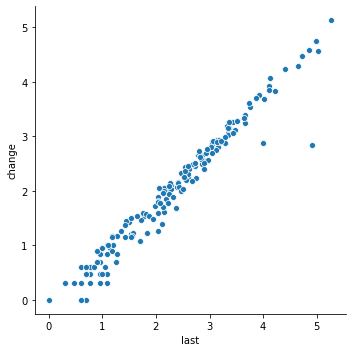

In [ ]:
# X log of total confirmed cases,  Y: new confirmed places (last week or so)
import seaborn as sb
sb.relplot(data=plot_data, x='last', y='change');

In [ ]:
fig = px.scatter(plot_data, x= 'last', y='change', hover_name='country',
                  width=800, height=800,
             title = 'China and South Korea have escaped the exponential growth')
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.show()